<a href="https://colab.research.google.com/github/sameh00alsharawy/machine-learning-/blob/master/arabic_sentiment_analysis_with_embedding_and_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive 
!gdown --id '1EbAUsvp7_d46k_AJo97c_Kkq2W92Szq6'
!gdown --id '1s675Wt46d0-TqoHPqgM46-kVa4E8_m-Y'
!gdown --id '1NKngN4pBT7nV9y6ALW6vI-w972r918-H'
!gdown --id '1MnyTd18BaP-KVNc2T_q6lmmek5KGVdVo'

Downloading...
From: https://drive.google.com/uc?id=1EbAUsvp7_d46k_AJo97c_Kkq2W92Szq6
To: /content/2class-balanced-test.txt
100% 22.5k/22.5k [00:00<00:00, 41.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1s675Wt46d0-TqoHPqgM46-kVa4E8_m-Y
To: /content/2class-balanced-train.txt
100% 89.9k/89.9k [00:00<00:00, 32.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NKngN4pBT7nV9y6ALW6vI-w972r918-H
To: /content/NEGATIVE.txt
100% 253/253 [00:00<00:00, 340kB/s]
Downloading...
From: https://drive.google.com/uc?id=1MnyTd18BaP-KVNc2T_q6lmmek5KGVdVo
To: /content/reviews.tsv
39.9MB [00:00, 96.2MB/s]


In [ ]:
!pip install pyarabic

     |████████████████████████████████| 112kB 4.5MB/s 
  Created wheel for pyarabic: filename=PyArabic-0.6.8-cp36-none-any.whl size=110609 sha256=34d4a6930d99bcd5e72f00e9cacc3a6a80d9f6e4b0877eb0ca47141beb129e1a
  Stored in directory: /root/.cache/pip/wheels/ca/fa/26/d82414a6635b3ee82bee0729bfdb1dc8d09879742206e004bb
Successfully built pyarabic


In [ ]:
!pip install gensim nltk

In [ ]:
!wget https://bakrianoo.s3-us-west-2.amazonaws.com/aravec/full_uni_cbow_100_twitter.zip

--2020-08-20 22:00:15--  https://bakrianoo.s3-us-west-2.amazonaws.com/aravec/full_uni_cbow_100_twitter.zip
Resolving bakrianoo.s3-us-west-2.amazonaws.com (bakrianoo.s3-us-west-2.amazonaws.com)... 52.218.245.9
Connecting to bakrianoo.s3-us-west-2.amazonaws.com (bakrianoo.s3-us-west-2.amazonaws.com)|52.218.245.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962251835 (918M) [application/zip]
Saving to: ‘full_uni_cbow_100_twitter.zip’

full_uni_cbow_100_t 100%[===================>] 917.67M  27.1MB/s    in 36s     

2020-08-20 22:00:52 (25.4 MB/s) - ‘full_uni_cbow_100_twitter.zip’ saved [962251835/962251835]



In [ ]:
!unzip full_uni_cbow_100_twitter.zip

Archive:  full_uni_cbow_100_twitter.zip
  inflating: full_uni_cbow_100_twitter.mdl  
  inflating: full_uni_cbow_100_twitter.mdl.trainables.syn1neg.npy  
  inflating: full_uni_cbow_100_twitter.mdl.wv.vectors.npy  


In [ ]:
import gensim

encoder = gensim.models.Word2Vec.load('full_uni_cbow_100_twitter.mdl')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import pyarabic.araby as araby
import os
from sklearn.metrics import accuracy_score

import nltk
from nltk.corpus import stopwords

from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Embedding, Dropout, Flatten, BatchNormalization, Input
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split



In [ ]:
most_similar = encoder.wv.most_similar('مصر')
for i, j in most_similar:
  print(i , j)

تونس 0.8415080904960632
ليبيا 0.8191641569137573
تركيا 0.7924618124961853
بورسعيد 0.7904039621353149
الجزائر 0.7894656658172607
السودان 0.7706625461578369
القاهره 0.7667017579078674
سيناء 0.7660335898399353
ومصر 0.7509731650352478
السويس 0.7475086450576782


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
from nltk.stem.isri import ISRIStemmer

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
file1=open('2class-balanced-train.txt', 'r')
train_idx = [int(x) for x in file1.read().split('\n')]
file1.close()

file2=open('2class-balanced-test.txt', 'r')
test_idx=[int(x) for x in file2.read().split('\n')]
file2.close()

In [ ]:
reviews= pd.read_csv('reviews.tsv', sep='\t', names=['rating', 'review_id', 'user_id', 'book_id', 'review'])

In [ ]:
train_reviews = reviews.iloc[train_idx, [0, -1]]
test_reviews = reviews.iloc[test_idx, [0, -1]]
train_reviews.rating = train_reviews.rating.apply(lambda x : 0 if x<3 else 1)
test_reviews.rating = test_reviews.rating.apply(lambda x : 0 if x<3 else 1)
reviews = pd.concat([train_reviews, test_reviews])

In [ ]:
stop_words = stopwords.words('arabic')

file1=open('NEGATIVE.txt', 'r')
neg = [x for x in file1.read().split('\n')]
file1.close()

n = len(stop_words)

for word in neg:
  if word in stop_words:
    stop_words.remove(word)

print('{} stop words has been deleted'.format(n-len(stop_words)))

16 stop words has been deleted


In [ ]:
x=reviews.review.values
y=reviews.rating.values

In [ ]:
st = ISRIStemmer()

In [ ]:
x = [st.suf32(re.sub('[^\w]+|_]', ' ', araby.strip_tashkeel(review))) for review in x]

In [ ]:
len(x)

16448

**setting the maximum number of words in one sentence to be 100**

In [ ]:
max_length = 100
X=[]
Y=[]
for i in range(len(x)):
  if len(x[i].split())<=100:
    X.append(x[i].split())
    Y.append(y[i])
  else:
    X.append(x[i].split()[:100]) 
    Y.append(y[i])

In [ ]:
len(X), len(Y)

(16448, 16448)

**creating a list with the name vocab containing all the unique words and a dictionary with the name vocab_dict mapping each word to index**

In [ ]:
vocab=[]
for sentence in X:
  for word in sentence:
    if word not in vocab :
      vocab.append(word)

In [ ]:
len_vocab=len(vocab)

In [ ]:
len_vocab

85787

In [ ]:
vocab_dict = {}
for i in range(len(vocab)):
  vocab_dict[vocab[i]]=i

**representing each sentence with a sequence of indices**

In [ ]:
X_indices =np.zeros((len(X), 100))
for i in range(len(X)):
  sentence_words = X[i]
  j=0
  for w in sentence_words:
    X_indices[i, j] = vocab_dict[w]
    j=j+1


In [ ]:
X_indices.shape

(16448, 100)

**creating embedding matrix with shape (number of unique words+1, 100), some words don't have a representation, i reoresent it with zeros vector, and set the embedding layer to be trainable**

In [ ]:
emb_matrix = np.zeros((len_vocab+1, 100))
j=0
for word, idx in vocab_dict.items():
  try:
    emb_matrix[idx, :] = encoder.wv.get_vector(word)
  except:
    j=j+1  


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_indices,np.array( Y) , test_size=0.25, shuffle=False)

In [ ]:
sentence_indices = Input(shape=(100,), dtype='int32')

embedding_layer = Embedding(input_dim=len_vocab+1, output_dim=100, weights=[emb_matrix], trainable= True)
embeddings = embedding_layer(sentence_indices)

X = LSTM(128, return_sequences=True)(embeddings)
# Add dropout with a probability of 0.5
X = Dropout(0.8)(X)
# Propagate X trough another LSTM layer with 128-dimensional hidden state
# The returned output should be a single hidden state, not a batch of sequences.
X = LSTM(128, return_sequences=False)(X)
# Add dropout with a probability of 0.5
X = Dropout(0.8)(X)
# Propagate X through a Dense layer with 5 units
X = Dense(1, activation='sigmoid')(X)

model=Model(sentence_indices, X)

model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 100)          8578800   
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 128)          117248    
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
hist=model.fit(
    X_train,
    Y_train,
    epochs = 10,
    batch_size = 32,
    shuffle=True,
    validation_split=0.2
    )

Epoch 1/10
309/309 [==============================] - 30s 96ms/step - loss: 0.6580 - accuracy: 0.6500 - val_loss: 1.2298 - val_accuracy: 4.0519e-04
Epoch 2/10
309/309 [==============================] - 29s 94ms/step - loss: 0.5969 - accuracy: 0.6868 - val_loss: 0.7035 - val_accuracy: 0.8610
Epoch 3/10
309/309 [==============================] - 29s 93ms/step - loss: 0.4926 - accuracy: 0.7864 - val_loss: 0.6124 - val_accuracy: 0.7188
Epoch 4/10
309/309 [==============================] - 29s 93ms/step - loss: 0.3779 - accuracy: 0.8554 - val_loss: 0.6557 - val_accuracy: 0.7034
Epoch 5/10
309/309 [==============================] - 29s 93ms/step - loss: 0.2642 - accuracy: 0.9119 - val_loss: 1.1311 - val_accuracy: 0.6256
Epoch 6/10
309/309 [==============================] - 29s 92ms/step - loss: 0.1711 - accuracy: 0.9455 - val_loss: 1.1351 - val_accuracy: 0.6106
Epoch 7/10
309/309 [==============================] - 29s 93ms/step - loss: 0.1112 - accuracy: 0.9692 - val_loss: 1.5919 - val_accur

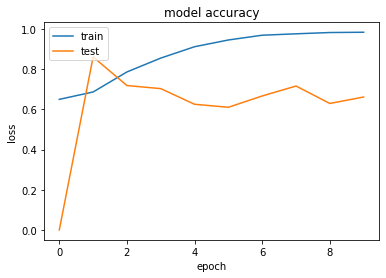

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

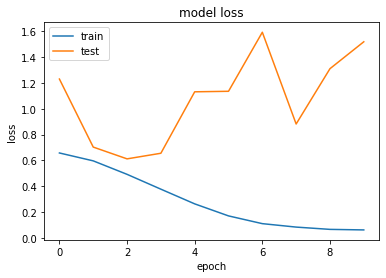

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model.evaluate(X_test, Y_test)

129/129 [==============================] - 1s 7ms/step - loss: 1.1100 - accuracy: 0.7305


In [ ]:
print('Model Loss     : {}'.format(loss))
print('Model accuracy : {}%'.format(acc*100))

Model Loss     : 1.1100200414657593
Model accuracy : 73.05447459220886%
